<a href="https://colab.research.google.com/github/KoMurase/FNC/blob/master/FNC_datavis_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
path = "/content/drive/My Drive/FNC/dataset/fake news detection(FakeNewsNet)"

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train = pd.read_csv(path + "/fnn_train.csv")
val = pd.read_csv(path + "/fnn_dev.csv")

In [5]:
train.shape, val.shape

((15212, 8), (1058, 8))

In [6]:
train = train.sample(10000)

In [7]:
def length(text):
  return len(text.split(' ') )

In [8]:
train["length"] = train["fullText_based_content"].apply(length)

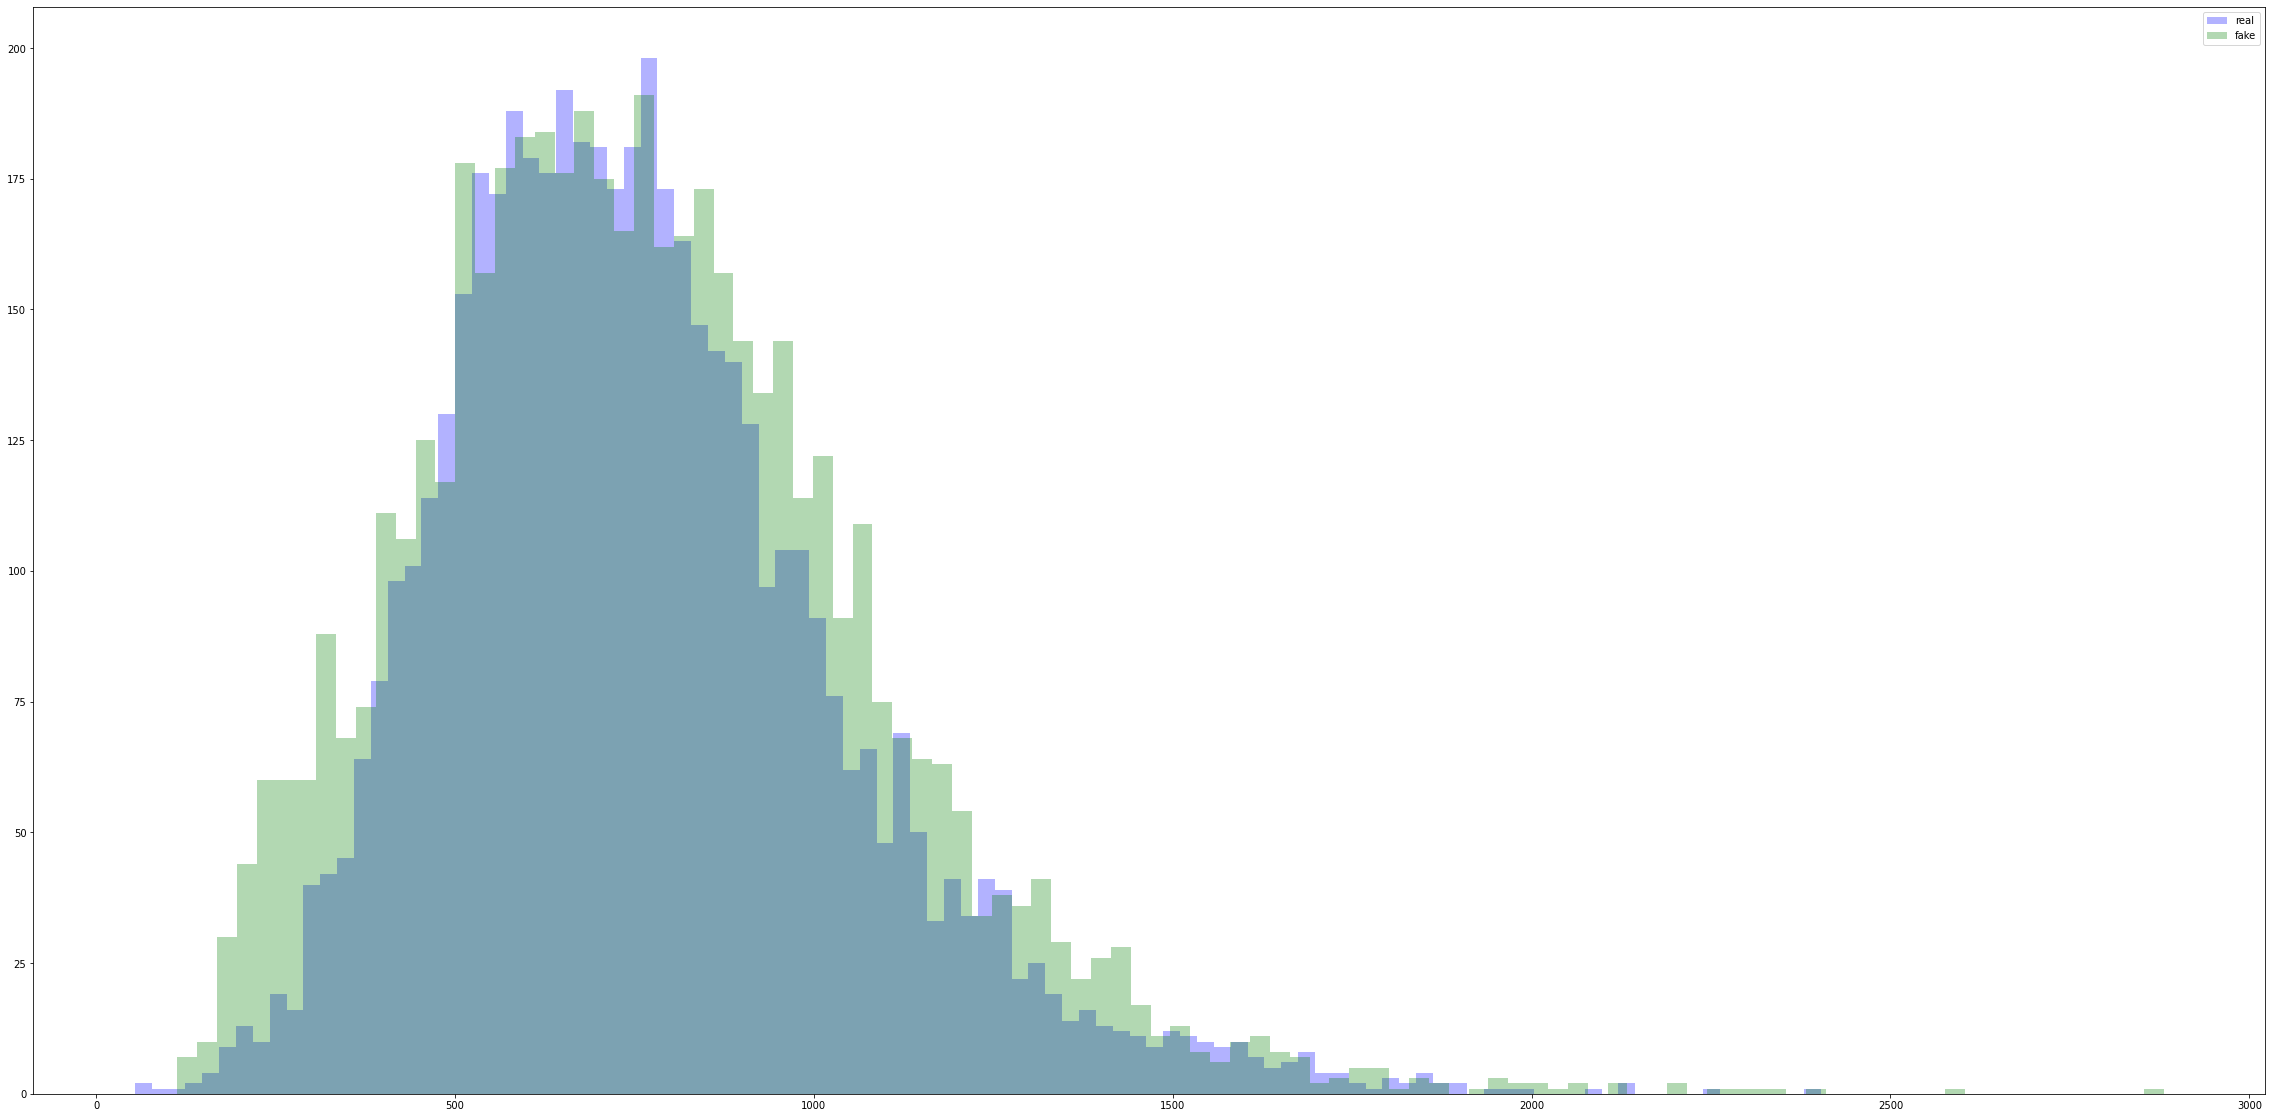

In [9]:
fig , ax = plt.subplots(1, 1, figsize = (40,20), sharey=True)
#labels =['Data scientist', 'Machine learning engineer', 'Software engineer', 'Consultant'] 
colors = ["blue","green"]
labels = ["real", "fake"]
bins = 100

for i, l in enumerate(labels):
    ax.hist(train[train["label_fnn"]==l]["length"],bins=bins,alpha=0.3, color=colors[i], label=labels[i]) 
    ax.legend(loc=0)

In [10]:
fake = train[train["label_fnn"]=='fake']
real = train[train["label_fnn"]=="real"]

In [11]:
fake["speaker"].value_counts()

Donald Trump      324
Facebook posts    315
Viral image       211
Bloggers          170
Chain email       103
                 ... 
Jeff Wentworth      1
Steve Chabot        1
Jane Kidd           1
Rick Range          1
Marvin Pratt        1
Name: speaker, Length: 1724, dtype: int64

In [12]:
real["speaker"].value_counts()

Barack Obama       225
Donald Trump       121
Hillary Clinton     94
Scott Walker        69
Rick Scott          63
                  ... 
Martavius Jones      1
Eva Longoria         1
Patrick Wales        1
Roland Martin        1
Jamie Oliver         1
Name: speaker, Length: 1984, dtype: int64

In [13]:
fake_sentences = fake["fullText_based_content"].tolist()

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000)  # 出現頻度上位{num_words}だけを用いる
tokenizer.fit_on_texts(fake_sentences)
print(list(tokenizer.word_index)[:10] ) # 学習された辞書（出現頻度順）


['the', 'to', 'of', 'a', 'in', 'and', 'that', 'for', 'is', 'on']


In [15]:
print(list(tokenizer.word_index)[:100] )

['the', 'to', 'of', 'a', 'in', 'and', 'that', 'for', 'is', 'on', 'said', 'it', 'was', 'as', 'by', 'not', 'we', 'with', 'he', 'from', 'but', 'at', 'an', 'have', 'are', 'be', 'about', 'has', 'this', 'or', 'would', 'his', 'state', 'they', 'more', 'who', 'percent', 'one', 'which', 'were', 'tax', 'than', 'so', 'if', 'had', 'no', 'when', 'their', 'people', 'other', 'been', 'i', 'you', 'there', 'health', 'out', 'what', 'also', 'law', 'new', 'all', 'up', 'year', 's', 'some', 'u', 'claim', 'its', 'our', 'will', 'president', 'states', 'obama', 'million', 'did', 'bill', 'she', 'years', 'federal', '000', 'those', 'two', 'trump', 'campaign', 'us', 'news', 'any', 'time', 'because', 'care', 'after', '1', 'government', 'over', 'house', 'could', 'it’s', 'can', 'first', 'according']


In [16]:
import string 

def remove_punct(text):
  table = str.maketrans('', '', string.punctuation)
  return text.translate(table)

In [17]:
train["full_text"] = train["fullText_based_content"].apply(remove_punct)
val["full_text"] = val["fullText_based_content"].apply(remove_punct)

In [18]:
def create_corpus(target):
  corpus = []

  for x in train[train["label_fnn"]==target]["full_text"].str.split():
    for i in x:
      corpus.append(i)
  
  return corpus 

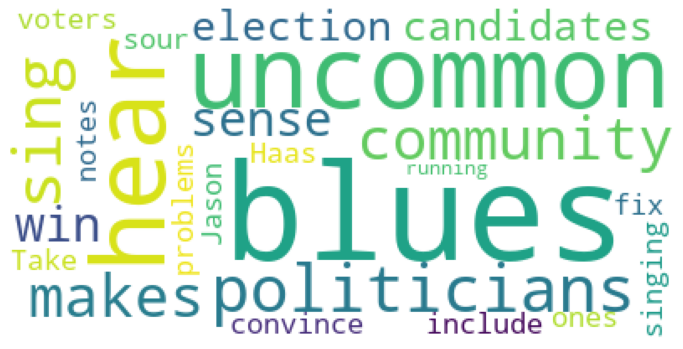

In [19]:
from wordcloud import WordCloud
 
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(create_corpus("fake")[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

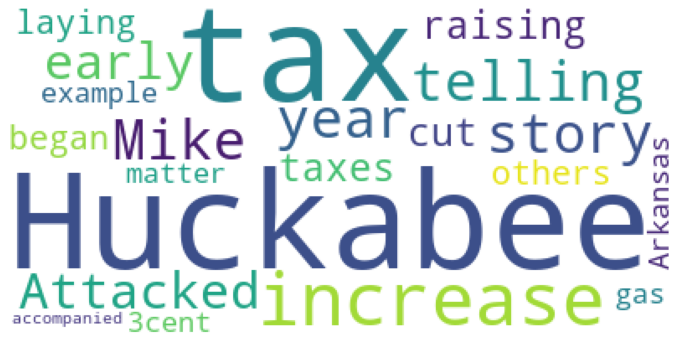

In [20]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(create_corpus("real")[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [21]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
  count_vectorizer = CountVectorizer()

  emb = count_vectorizer.fit_transform(data)

  return emb, count_vectorizer 

list_corpus = train["full_text"].tolist()

def encode(label):
  if label == "fake":
    return 1
  elif label == "real":
    return 0 

#list_labels = train["label_fnn"].tolist() 


In [22]:
train['flg'] = train["label_fnn"].apply(encode)
list_labels = train['flg'].tolist() 

print(list_labels[0:10])

[1, 0, 1, 1, 1, 1, 1, 1, 0, 0]


In [23]:
val['flg'] = val["label_fnn"].apply(encode)

In [24]:
counts, count_vectorizer = cv(list_corpus)

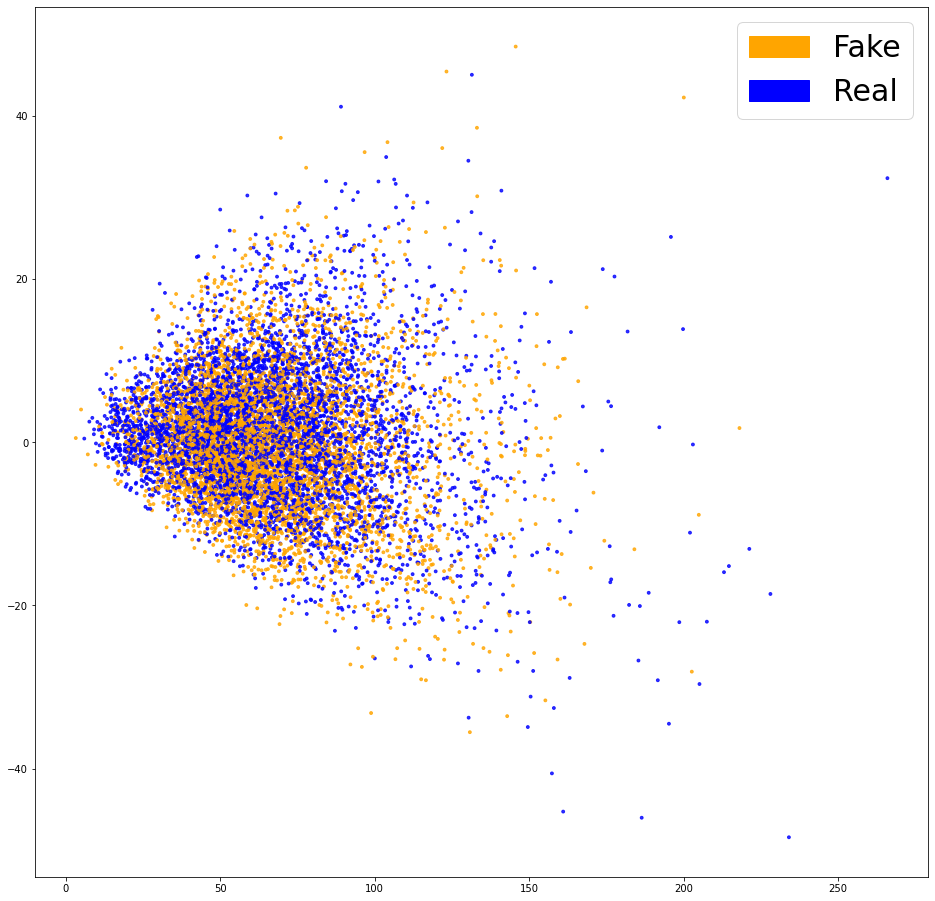

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Fake')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))          
plot_LSA(counts, list_labels)
plt.show()

In [26]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

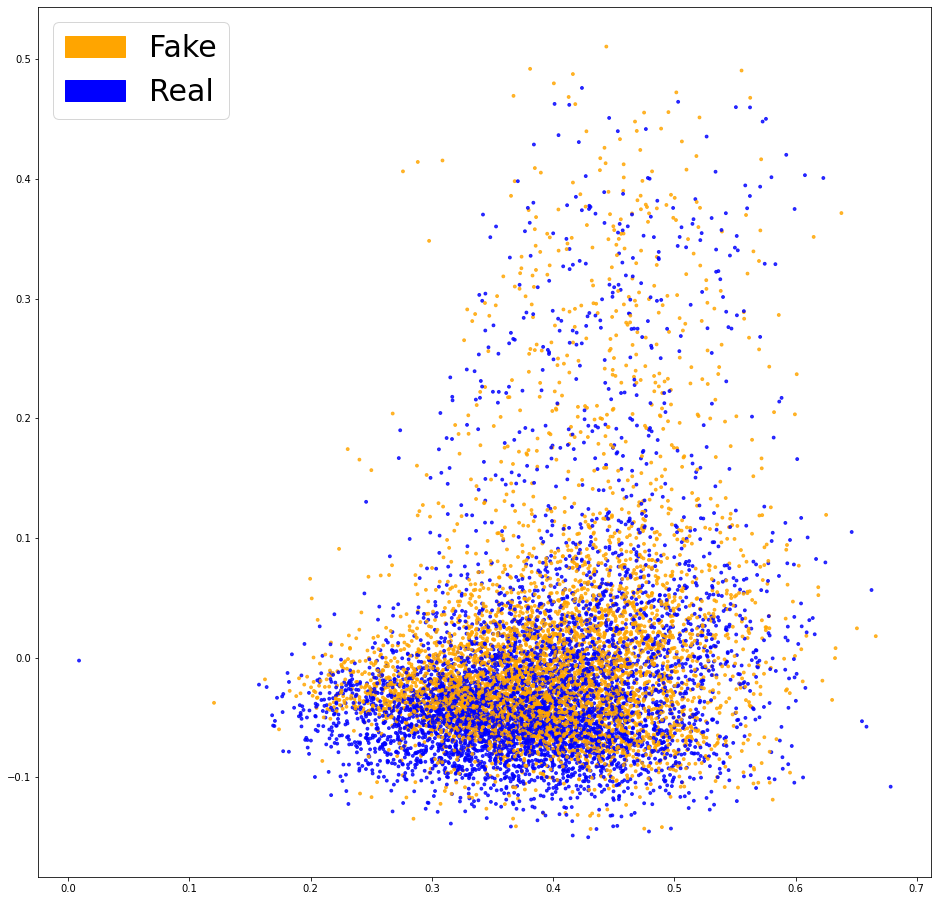

In [27]:
X_train_tfidf, tfidf_vectorizer = tfidf(train["full_text"])
#X_test_tfidf = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, list_labels)
plt.show()


In [28]:
train["paragraph_based_content"].iloc[0]

'[\'It’s not uncommon to hear politicians sing the blues about a community. It makes sense -- to win an election, candidates have to convince voters they are the ones who can fix the problems.\', \'But singing the blues can include some sour notes.\', \'Take Jason Haas, who is running for the 14th District seat on the Milwaukee County Board. In a statement to the Bay View Compass newspaper, he made a claim about Milwaukee County transit options that might make a voter in his district want to pony up more tax dollars for public transportation.\', "Haas and his opponent, trucking company owner Steve Kraeger, submitted written responses to questions from the Compass, which appeared in the newspaper\'s Feb. 27, 2011 issue .", \'In one of his responses, Haas discussed his views on the importance of public transit, including this observation:\', \'"Businesses have decided not to locate (in Milwaukee) precisely because there are no effective transit options; Milwaukee lost the headquarters of

In [29]:
def count_vague_words(data):
  
  data["count_maybe"] = data["full_text"].apply(lambda x: x.lower().count('maybe'))
  data["count_probably"] = data["full_text"].apply(lambda x: x.lower().count('probably'))
  data["count_perhaps"] = data["full_text"].apply(lambda x: x.lower().count('perhaps'))

  return data

In [30]:
train= count_vague_words(train)
train["count_maybe"].value_counts()

0    9626
1     318
2      49
3       7
Name: count_maybe, dtype: int64

In [31]:
train.head()

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn,length,full_text,flg,count_maybe,count_probably,count_perhaps
2165,3522,2011-04-02T08:00:00-04:00,Jason Haas,Milwaukee lost the headquarters for MillerCoor...,['http://www.jsonline.com/business/29453314.ht...,['It’s not uncommon to hear politicians sing t...,It’s not uncommon to hear politicians sing the...,fake,778,It’s not uncommon to hear politicians sing the...,1,0,0,0
14155,257,2008-01-03T00:00:00-05:00,Mike Huckabee,"""...some of those (tax increases) were either ...","[""http://www.thefreelibrary.com/Truckers+Rate+...",['Mike Huckabee has been telling the same stor...,Mike Huckabee has been telling the same story ...,real,695,Mike Huckabee has been telling the same story ...,0,0,0,0
4868,11693,2015-12-16T13:52:53-05:00,Ted Cruz,"Says carpet bombing means bombing ""not a city,...",['http://www.cq.com/doc/newsmakertranscripts-4...,['In the wake of the apparently ISIS-inspired ...,In the wake of the apparently ISIS-inspired te...,fake,837,In the wake of the apparently ISISinspired ter...,1,0,0,0
10750,16114,2018-10-29T15:44:50-04:00,Congressional Leadership Fund,"Says Dan Feehan ""would vote with Pelosi for op...",['https://www.youtube.com/watch?v=YZrybJoDPE0&...,['A new ad from a Republican-backed super PAC ...,A new ad from a Republican-backed super PAC ha...,fake,765,A new ad from a Republicanbacked super PAC has...,1,0,0,0
13147,2163,2010-08-02T12:30:00-04:00,Lee Fisher,"""As President George W. Bush’s trade represent...",['http://www.cleveland.com/open/index.ssf/2010...,['China makes the goods that Americans used to...,China makes the goods that Americans used to m...,fake,1451,China makes the goods that Americans used to m...,1,0,0,0


In [32]:
train["full_text"].iloc[0]

'It’s not uncommon to hear politicians sing the blues about a community It makes sense  to win an election candidates have to convince voters they are the ones who can fix the problems\nBut singing the blues can include some sour notes\nTake Jason Haas who is running for the 14th District seat on the Milwaukee County Board In a statement to the Bay View Compass newspaper he made a claim about Milwaukee County transit options that might make a voter in his district want to pony up more tax dollars for public transportation\nHaas and his opponent trucking company owner Steve Kraeger submitted written responses to questions from the Compass which appeared in the newspapers Feb 27 2011 issue \nIn one of his responses Haas discussed his views on the importance of public transit including this observation\nBusinesses have decided not to locate in Milwaukee precisely because there are no effective transit options Milwaukee lost the headquarters of MillerCoors to Chicago in large part for that

###modeling 
###plan 
1. bag-of-words → logistic regression 
2. tf-idf →logistic regression 
3. bag-of-words + tf-idf → logistic regression 

In [33]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [34]:
val.head()

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn,full_text,flg
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake,Gov Charlie Crist launched what amounts to a n...,1
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real,US Rep Bobby Scott D3rd was not pleased with t...,0
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake,Amid reports questioning Foxconn Technology Gr...,1
3,1557,2010-03-05T18:24:02-05:00,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","['http://www.davearonberg.com/about', 'http://...","[""State Sen. Dave Aronberg, a Democratic candi...","State Sen. Dave Aronberg, a Democratic candida...",real,State Sen Dave Aronberg a Democratic candidate...,0
4,12826,2016-07-29T18:09:31-04:00,Jeannette Vaught,"""Only five Texas counties account for almost 9...",['http://www.mystatesman.com/news/news/opinion...,['From the citrus of the Rio Grande Valley to ...,From the citrus of the Rio Grande Valley to th...,fake,From the citrus of the Rio Grande Valley to th...,1


In [35]:
sentences = train["full_text"].to_list() + val["full_text"].to_list()

In [36]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000)  # 出現頻度上位{num_words}だけを用いる
tokenizer.fit_on_texts(sentences)

In [37]:
tokenizer.texts_to_matrix(sentences, mode='binary')

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [38]:
tokenizer.filters

'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

In [39]:
tokenizer.document_count

11058

In [40]:
tokenizer.char_level

False

In [41]:
tokenizer.index_docs

defaultdict(int,
            {9900: 43,
             61: 6931,
             3461: 183,
             1356: 669,
             91: 5375,
             1878: 385,
             1393: 706,
             4932: 134,
             1376: 538,
             961: 1068,
             24557: 4,
             186: 1588,
             8982: 45,
             566: 1262,
             9308: 20,
             2737: 243,
             491: 1467,
             3133: 196,
             1015: 972,
             231: 3275,
             13: 10261,
             262: 2102,
             2248: 361,
             1846: 374,
             1082: 875,
             16537: 17,
             12: 10455,
             41: 8580,
             1339: 600,
             1: 11058,
             1556: 468,
             88: 5435,
             768: 1251,
             878: 1114,
             164: 2837,
             1100: 861,
             122: 1682,
             715: 934,
             181: 3784,
             80: 6172,
             12856: 22,
          

In [42]:
tokenizer.index_word

{1: 'the',
 2: 'to',
 3: 'of',
 4: 'a',
 5: 'in',
 6: 'and',
 7: 'that',
 8: 'for',
 9: 'is',
 10: 'on',
 11: 'said',
 12: 'it',
 13: 'was',
 14: 'as',
 15: 'by',
 16: 'we',
 17: 'with',
 18: 'from',
 19: 'not',
 20: 'but',
 21: 'he',
 22: 'at',
 23: 'are',
 24: 'have',
 25: 'an',
 26: 'be',
 27: 'has',
 28: 'about',
 29: 'or',
 30: 'this',
 31: 'would',
 32: 'his',
 33: 'percent',
 34: 'state',
 35: 'us',
 36: 'more',
 37: 'they',
 38: 'who',
 39: 'than',
 40: 'were',
 41: 'which',
 42: 'tax',
 43: 'one',
 44: 'so',
 45: 'if',
 46: 'its',
 47: 'when',
 48: 'other',
 49: 'had',
 50: 'their',
 51: 'people',
 52: 'also',
 53: 'new',
 54: 'been',
 55: 'there',
 56: 'you',
 57: 'out',
 58: 'states',
 59: 'all',
 60: 'health',
 61: 'some',
 62: 'no',
 63: 'up',
 64: 'year',
 65: 'what',
 66: 'law',
 67: 'i',
 68: 'million',
 69: 'years',
 70: 'claim',
 71: 'federal',
 72: 'our',
 73: 'will',
 74: 'those',
 75: 'bill',
 76: 'obama',
 77: 'president',
 78: 'did',
 79: 'she',
 80: 'because',
 

In [43]:
tokenizer.word_docs

defaultdict(int,
            {'observation': 43,
             'some': 6931,
             'company’s': 183,
             'lack': 669,
             'can': 5375,
             'options': 385,
             'appeared': 706,
             'maintains': 134,
             'choice': 538,
             'referred': 1068,
             'compass': 4,
             'county': 1588,
             'narrowed': 45,
             'association': 1262,
             'pony': 20,
             'owner': 243,
             'executive': 1467,
             '800': 196,
             'suggested': 972,
             'called': 3275,
             'was': 10261,
             'article': 2102,
             'chose': 361,
             'bay': 374,
             'written': 875,
             'sour': 17,
             'it': 10455,
             'which': 8580,
             'seat': 600,
             'the': 11058,
             'effective': 468,
             'it’s': 5435,
             'reason': 1251,
             'wasn’t': 1114,
             '2011

In [44]:
# 学習・検証に分けて，ベクトルを生成。加えて，正解ラベルも作成
train_X, test_X = np.split(tokenizer.texts_to_matrix(sentences, mode='binary'),
                           [len(train)], axis=0)

train_y = train['flg'].values  # maps {1, 2, 3 ,4} -> {0, 1, 2, 3}
train_X.shape, train_y.shape, test_X.shape

((10000, 1000), (10000,), (1058, 1000))

In [45]:
#define models 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [46]:
lr = LogisticRegression()
lr.fit(train_X, train_y) 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
predict = lr.predict(test_X)

In [48]:
pd.DataFrame(predict,columns={'predict'})["predict"].value_counts()

0    566
1    492
Name: predict, dtype: int64

In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('confusion matrix = \n', confusion_matrix(y_true=val["flg"], y_pred=predict))
print('accuracy = ', accuracy_score(y_true=val["flg"], y_pred=predict))
print('precision = ', precision_score(y_true=val["flg"], y_pred=predict))
print('recall = ', recall_score(y_true=val["flg"], y_pred=predict))
print('f1 score = ', f1_score(y_true=val["flg"], y_pred=predict))

confusion matrix = 
 [[389 151]
 [177 341]]
accuracy =  0.6899810964083176
precision =  0.693089430894309
recall =  0.6583011583011583
f1 score =  0.6752475247524752


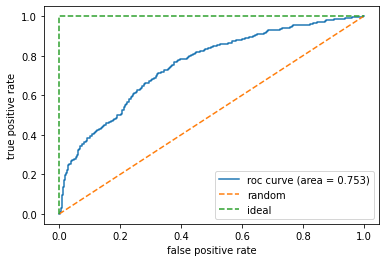

In [51]:
from sklearn.metrics import roc_curve, auc

Y_score = lr.predict_proba(test_X)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=val["flg"], y_score=Y_score)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [54]:
del train_X, train_y, test_X

In [55]:
TEXT_COL = "full_text" 

tfidf = TfidfVectorizer()
df = tfidf.fit_transform(pd.concat([train[TEXT_COL], val[TEXT_COL]], axis=0))
tfidf_df = pd.DataFrame(df.toarray(), columns=tfidf.get_feature_names())
tfidf_df

,00,000,000000000,0000003,000003,000005,0000056,00001,00005,00015,00026,0003,00039,0004,0005,00056,0006,0008,00092,001,0015,0017,002,00297,003,0031,004,0044,0047,005,00530,006,007,00792,008,00833,0085,00th,01,010,...,голоса,голосовать,как,кто,мир,мирович,неважно,но,оf,партии,пу,раrt,реаbrаіnеd,реорlе,ріg,сlаmоrіng,саn,совершенно,считать,считаю,тин,уоu,хоккей,чрезвычайно,что,это,яркий,ѕhе,ѕtrаіghtfоrwаrdlу,ѕuсh,ѕаtіrе,ѕоund,ѕосіаl,іf,іn,іt,іѕ,ḍozen,ﬁrearm,ﬁrms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
use_cols = []
thld_q90 = np.percentile(tfidf_df.std().values, 90)
for col in tfidf_df.columns:
    if thld_q90 < tfidf_df[col].std():
        use_cols.append(col)
tfidf_df = tfidf_df[use_cols]

In [61]:
tfidf_cols = {col:col+'_tfidf' for col in tfidf_df.columns}
tfidf_df = tfidf_df.rename(columns=tfidf_cols)


In [58]:
tfidf_df.shape

(11058, 9168)

In [59]:
train.shape, val.shape

((10000, 14), (1058, 10))

In [64]:
train_x = tfidf_df.iloc[:train.shape[0],:]
test_x = tfidf_df.iloc[train.shape[0]:,:]

del tfidf_df

In [65]:
import gc 
gc.collect()

348

In [67]:
lr = LogisticRegression()
lr.fit(train, list_labels) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

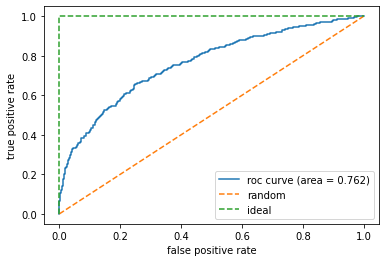

In [68]:
Y_score = lr.predict_proba(test)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=val["flg"], y_score=Y_score)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()